# Setup

In [1]:
import numpy as np

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

2025-10-24 05:51:55.927825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Tensorflow version:", tf.__version__)
print("Tensorflow Text version:", tf_text.__version__)
print("Einops version:", einops.__version__)
!python -V

Tensorflow version: 2.15.0
Tensorflow Text version: 2.15.0
Einops version: 0.8.1
Python 3.11.0


# Data

## Download and prepare the dataset

In [3]:
# Download the file
from pathlib import Path, PosixPath
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', 
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    cache_dir = '.',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'
print("File path: ", path_to_file)

File path:  datasets/spa-eng/spa.txt


In [4]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [5]:
target_raw, context_raw = load_data(path_to_file)
print(target_raw[100], context_raw[100])

Go away! ¡Salga de aquí!


## Create a tf.data dataset

In [6]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [7]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[0].numpy().decode('utf-8'))
  print()
  print(example_target_strings[0].numpy().decode('utf-8'))
  break

Hay miles de millones de estrellas en el universo.

There are billions of stars in the universe.


## Text preprocessing

### Standardize the text

In [8]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [9]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [10]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


### Text Vectorization

In [11]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [12]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))

# Here are the first 10 words from the vocabulary:
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [13]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 59, 2529, 6, 2042, 6, 1624, 14, 7, 2484, 4, 3],
 [2, 13, 21, 5, 98, 249, 58, 12, 3],
 [2, 29, 18, 216, 16, 446, 6, 275, 1, 4, 3]]>

In [14]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] hay miles de millones de estrellas en el universo . [END]'

In [15]:
target_tokens = target_text_processor(example_target_strings)
target_tokens[:3, :]

<tf.RaggedTensor [[2, 52, 28, 1, 15, 1513, 14, 5, 2082, 4, 3],
 [2, 78, 28, 51, 224, 21, 11, 3],
 [2, 26, 234, 22, 10, 2896, 398, 498, 4, 3]]>

In [16]:
target_vocab = np.array(target_text_processor.get_vocabulary())
tokens = target_vocab[target_tokens[0].numpy()]
' '.join(tokens)

'[START] there are [UNK] of stars in the universe . [END]'

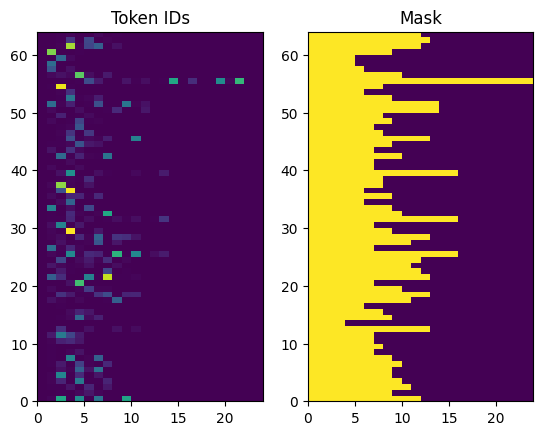

In [17]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask');

### Process the dataset

In [18]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [19]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print("context shape: ", ex_context_tok.shape)
  print("context tokens: ", ex_context_tok[0].numpy()) 
  print("context tokens (decoded): ", ' '.join(context_vocab[ex_context_tok[0].numpy()]))
  print()
  print("target in shape: ", ex_tar_in.shape)
  print("target in tokens: ", ex_tar_in[0].numpy()) 
  print("target in tokens (decoded): ", ' '.join(target_vocab[ex_tar_in[0].numpy()]))
  print()
  print("target out shape: ", ex_tar_out.shape)
  print("target out tokens: ", ex_tar_out[0].numpy()) 
  print("target out tokens (decoded): ", ' '.join(target_vocab[ex_tar_out[0].numpy()]))

context shape:  (64, 16)
context tokens:  [ 2 97  9 15 24 84  4  3  0  0  0  0  0  0  0  0]
context tokens (decoded):  [START] ese no es mi trabajo . [END]        

target in shape:  (64, 14)
target in tokens:  [  2 142  38  24 180   4   0   0   0   0   0   0   0   0]
target in tokens (decoded):  [START] thats not my job .        

target out shape:  (64, 14)
target out tokens:  [142  38  24 180   4   3   0   0   0   0   0   0   0   0]
target out tokens (decoded):  thats not my job . [END]        


# The encoder/decoder

In [20]:
UNITS = 256

## The encoder

In [21]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [22]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 16)
Encoder output, shape (batch, s, units): (64, 16, 256)


## The attention layer

In [23]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [24]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(), output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 16, 256)
Target sequence, shape (batch, t, units): (64, 14, 256)
Attention result, shape (batch, t, units): (64, 14, 256)
Attention weights, shape (batch, t, s):    (64, 14, 16)


In [25]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994], dtype=float32)

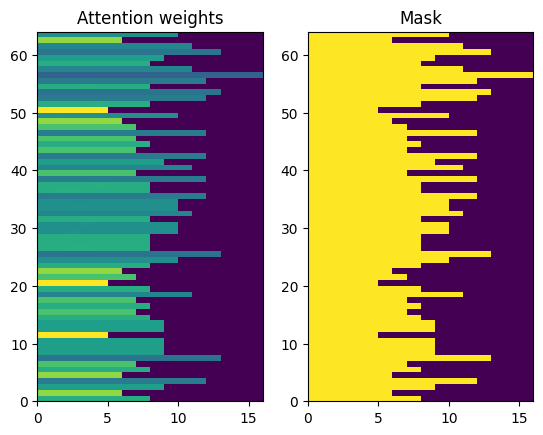

In [26]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

## The decoder

In [27]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)
  
  def build(self, input_shape):
    # This explicitly tells TensorFlow this layer is built
    self.built = True

In [28]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  

  # 1. Lookup the embeddings
  x = self.embedding(x)

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)

  if return_state:
    return logits, state
  else:
    return logits

In [29]:
decoder = Decoder(target_text_processor, UNITS)

In [30]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 16, 256)
input target tokens shape: (batch, t) (64, 14)
logits shape shape: (batch, target_vocabulary_size) (64, 14, 5000)


## The inference

In [31]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  ## this line breaks the code in new tf versions
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]
  # return start_tokens, done, self.rnn.get_initial_state(batch_size)[0]

In [32]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [33]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

### Generation loop

In [34]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'scheme picnic strategy should border silly lacks view credit existence',
       b'barked clean cage begun appropriate furniture korean server havent mad',
       b'misses crime swear postpone regarded hearing pizza cultural planting understanding'],
      dtype=object)

# Build the model

In [35]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    # #TODO(b/250038731): remove this
    # try:
    #   # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
    #   del logits._keras_mask
    # except AttributeError:
    #   pass

    return logits

In [36]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 16)
Target tokens, shape: (batch, t) (64, 14)
logits, shape: (batch, t, target_vocabulary_size) (64, 14, 5000)


## Define masked loss and accuracy functions

In [37]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [38]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    # Apply mask to matches to exclude padding positions
    match = match * mask

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [39]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

## Check baseline performance of untrained model

In [40]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [41]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 9s 115ms/step - loss: 8.5048 - masked_acc: 2.8353e-04 - masked_loss: 8.5048


{'loss': 8.504794120788574,
 'masked_acc': 0.0002835270715877414,
 'masked_loss': 8.504844665527344}

In [42]:
EPOCH = 100
history = model.fit(
    train_ds.repeat(), 
    epochs=EPOCH,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 43s 304ms/step - loss: 5.0367 - masked_acc: 0.2578 - masked_loss: 5.0368 - val_loss: 4.1240 - val_masked_acc: 0.3521 - val_masked_loss: 4.1249
Epoch 2/100
100/100 [==============================] - 31s 303ms/step - loss: 3.7250 - masked_acc: 0.4000 - masked_loss: 3.7269 - val_loss: 3.3873 - val_masked_acc: 0.4418 - val_masked_loss: 3.3881
Epoch 3/100
100/100 [==============================] - 28s 277ms/step - loss: 3.1212 - masked_acc: 0.4817 - masked_loss: 3.1235 - val_loss: 2.9036 - val_masked_acc: 0.5099 - val_masked_loss: 2.9049
Epoch 4/100
100/100 [==============================] - 28s 278ms/step - loss: 2.7179 - masked_acc: 0.5379 - masked_loss: 2.7196 - val_loss: 2.5052 - val_masked_acc: 0.5618 - val_masked_loss: 2.5076
Epoch 5/100
100/100 [==============================] - 31s 314ms/step - loss: 2.4095 - masked_acc: 0.5802 - masked_loss: 2.4119 - val_loss: 2.2409 - val_masked_acc: 0.6042 - val_masked_loss: 2.2441
Epoch 6/10

## Model training visualization

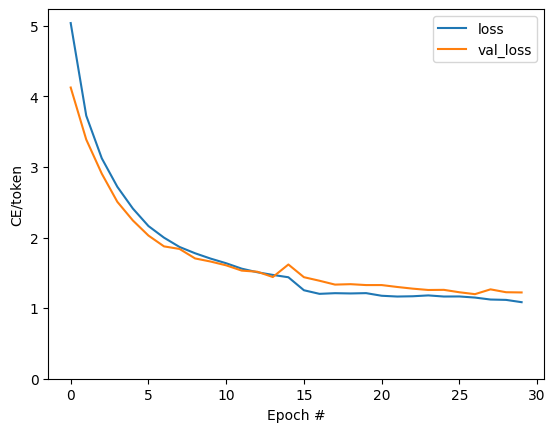

In [43]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend();

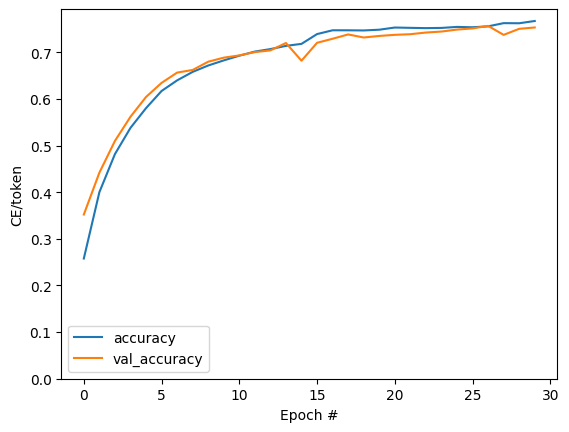

In [44]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend();

# Translate

In [45]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

# Plot Attention weights

In [46]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  print("Translation output: ", output)
  output = output[0].numpy().decode()
  print("Translation output: ", output)

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  xticks = np.arange(len(context))
  yticks = np.arange(len(output))

  ax.set_xticks(xticks)
  ax.set_xticklabels(context, fontdict=fontdict, rotation=90)

  ax.set_yticks(yticks)
  ax.set_yticklabels(output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

# Examples

In [47]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'is still at home ? '

Translation output:  tf.Tensor([b'is still at home ? '], shape=(1,), dtype=string)
Translation output:  is still at home ? 


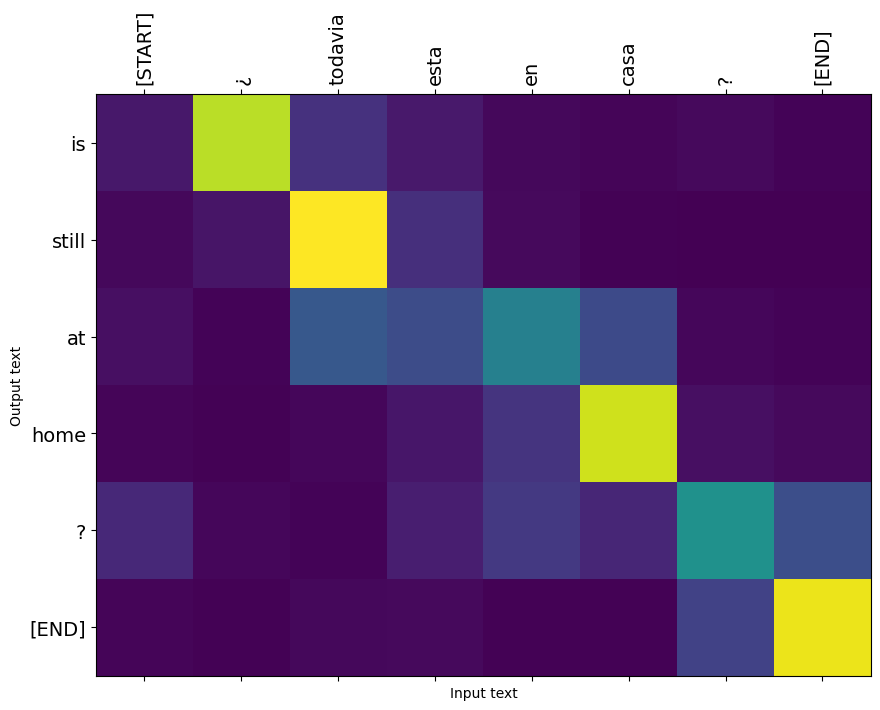

In [48]:
model.plot_attention('¿Todavía está en casa?'); # Are you still home

Translation output:  tf.Tensor([b'this is my life . '], shape=(1,), dtype=string)
Translation output:  this is my life . 
CPU times: user 343 ms, sys: 18.1 ms, total: 361 ms
Wall time: 336 ms


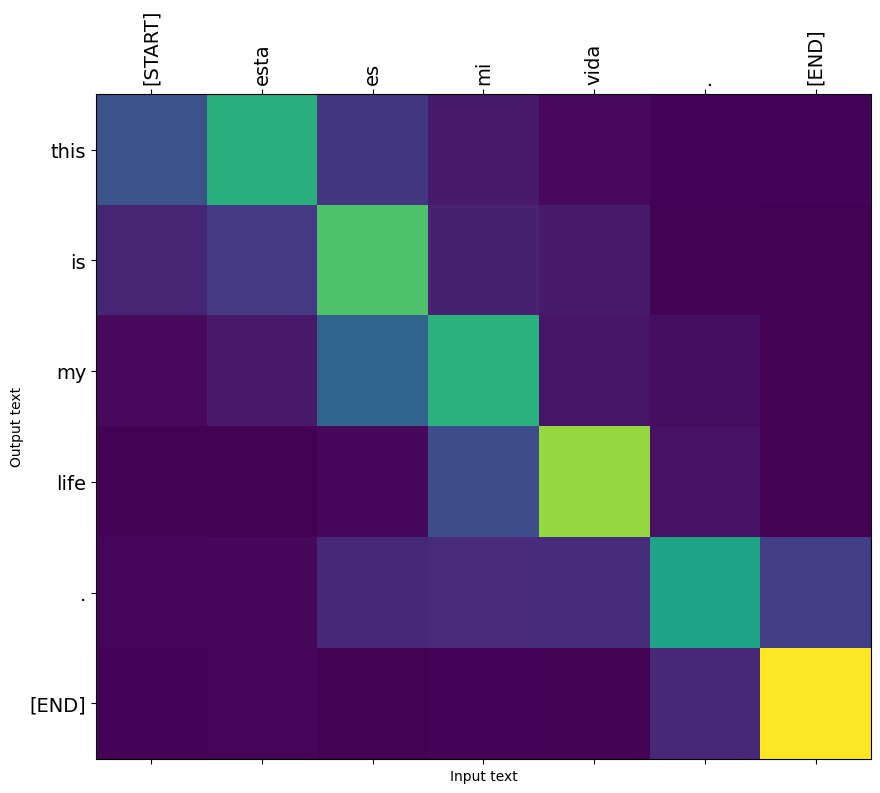

In [49]:
%%time
# This is my life.
model.plot_attention('Esta es mi vida.');

Translation output:  tf.Tensor([b'try to find out . '], shape=(1,), dtype=string)
Translation output:  try to find out . 
CPU times: user 333 ms, sys: 16.5 ms, total: 350 ms
Wall time: 325 ms


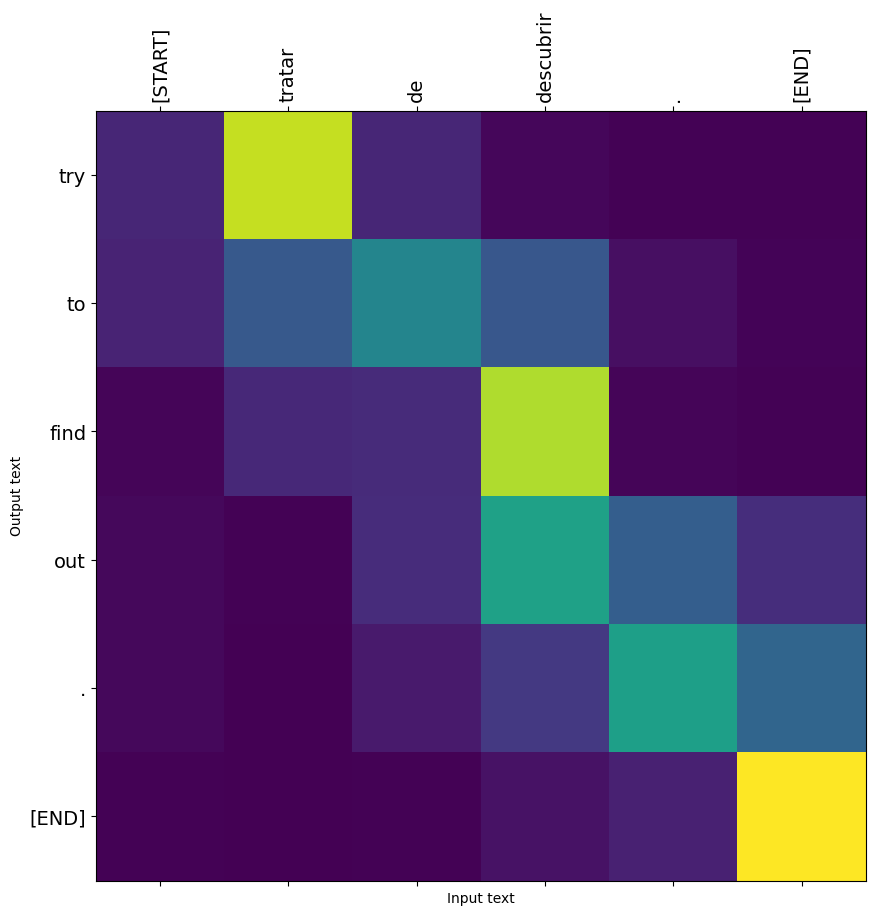

In [50]:
%%time
 # Try to find out.'
model.plot_attention('Tratar de descubrir.');

In [51]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


Translation output:  tf.Tensor([b'if you want to sound like a native speaker , you must be willing to practice the same phrase as a [UNK] time , and the same way as the same phrase as the same phrase as the same phrase as the same phrase as the same phrase as the'], shape=(1,), dtype=string)
Translation output:  if you want to sound like a native speaker , you must be willing to practice the same phrase as a [UNK] time , and the same way as the same phrase as the same phrase as the same phrase as the same phrase as the same phrase as the


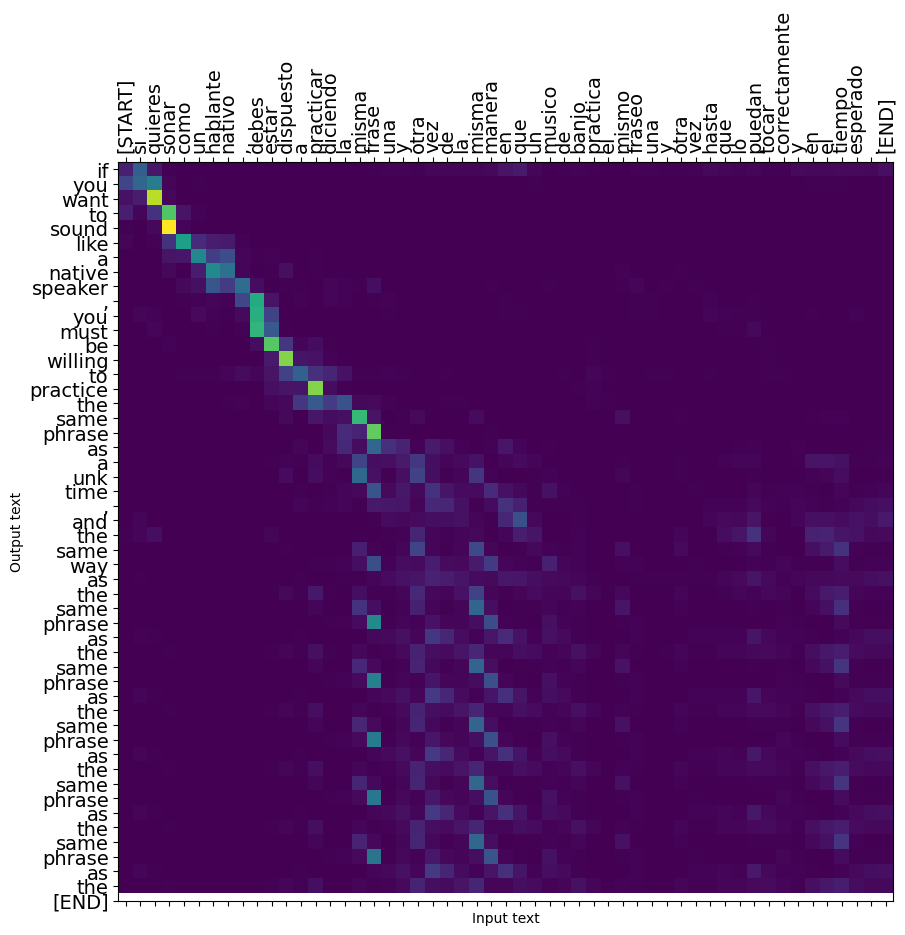

In [52]:
model.plot_attention(long_text);

In [53]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

In [54]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a disaster . 

CPU times: user 336 ms, sys: 9.66 ms, total: 346 ms
Wall time: 327 ms
